# ex2.1 jack's car rental solving

## See p. 81 (section 4.3, example 4.2) in Sutton's Reinforcement learning: An introduction

Goal:

- implementing value iteration in dynamic programming

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## copy the code from ex2.0 here

Note: numba's jit could compile python's code to near native performance. If you can use it without problems, good for you, if not, just remove the line `@jit(nopython=True)`.

In [73]:
import numpy as np
from scipy.stats import poisson
from numba import jit

N_CARS = 20

# renting and returning propabilities
P_RETURN_A = poisson.pmf(np.arange(0, N_CARS + 1), 3)
P_RENT_A = poisson.pmf(np.arange(0, N_CARS + 1), 3)
P_RETURN_B = poisson.pmf(np.arange(0, N_CARS + 1), 2)
P_RENT_B = poisson.pmf(np.arange(0, N_CARS + 1), 4)

def step_rent(n_car, p):
    """return probability distribution over the number of cars after rent"""
    # code here ...
    # ...
    pp = []
    r=0
    c = n_car
    for i in range(0, N_CARS+1):
        if c>=0:
            pp.append(p[c])
        else:
            pp.append(0.0)
        c -= 1
        
        if i < n_car+1:
            r += (i * p[i])
        else:
            r += ((n_car) * p[i])
    r *= 10
    # pp is the probability over cars after rent
    # r is the expected reward
    return np.array(pp), r

def step_return(p_car, p):
    """return a distribution over the number of cars aftern returned"""
    # code here ...
    # ...
    pp = []
    for j in range(0, N_CARS+1):
        pp.append(np.sum(p_car[:j+1] * np.flip(p[:j+1])))
    # pp is the probability over cars after return
    return np.array(pp)

def step_rent_return(n_car, p_rent, p_return):
    """probability after rent and return for one day"""
    p, r = step_rent(n_car, p_rent)
    p = step_return(p, p_return)
    return p, r

def step_env(s, a):
    """step a on state s, returning the next state distribution and the expected reward"""
    # s = (N_CARS_IN_A, N_CARS_IN_B)
    # move cars
    # code here ..
    p = np.zeros([N_CARS+1,N_CARS+1])
    
    i = s[0]-a
    j = s[1]+a
    p_a, r_a = step_rent_return(i, P_RENT_A, P_RETURN_A)
    p_b, r_b = step_rent_return(j, P_RENT_B, P_RETURN_B)
    
    p = np.outer(p_a, p_b)
    p = p/np.sum(p)
    
    # ...
    # renting and returning
    
    r = (-2)*np.abs(a) + r_a + r_b
    
    # p is the "joint" probability over cars at first and second location
    # p has the shape of [N_CARS+1, N_CARS+1] where the dim=0 is the first location, dim=1 is the second location
    # r is the expected reward
    return p, r

# value iteration

implement the value iteration to solve this Jack's car rental problem.

In [74]:
def value_itr(v, thresh=1e-4):
    """implement the value iteration algorithm"""
    # v = value table, has a shape of [N_CARS+1, N_CARS+1]
    # make change to the v in-place
    # code here ...
    discount_factor = 0.9
    
    while True:
        diff = 0.

        # For loop each state 
        for i in range(0, N_CARS+1):
            for j in range(0, N_CARS+1):
                
                # Step1: Get value
                value = v[i][j]
                
                # Step2: Bell man equation
                a_min = max(-5,-j,-(N_CARS-i))
                a_max = min(5,i,N_CARS-j)
                max_a = []
                for a in range(a_min,a_max+1):
                    if 0 <= (i-a) and 0 <= (j+a):
                        p , r = step_env((i,j), a)
                        expected_reward = r + (discount_factor * np.sum(p * v))
                    max_a.append(expected_reward)
                v[i][j] = max(max_a)       
                
                # Step3: Calculate diff
                diff = max(diff, abs(v[i][j] - value))
        print(diff)        
        if diff < thresh:
            break 

## verify the solution value

260.97388171643706
140.583735012212
89.99790386445966
69.81803705624966
53.8459418523077
42.927779714812345
35.55849880279999
29.279525439849294
24.036962029149265
19.70305180277643
16.135683419000827
13.205343191656027
10.803132332903544
8.835943116798717
7.225649075928402
5.908115424684979
4.830561544158229
3.9494966197017334
3.229150220989254
2.64020297409877
2.1586836890829773
1.7650037958788403
1.4431517735704347
1.1800217583724475
0.9648909869889621
0.7889960383649282
0.64517557942645
0.5275770470257157
0.4314170517876619
0.352785790934945
0.28848715155066884
0.23590815982123559
0.19291242222232086
0.15775311029216255
0.12900187231025484
0.1054907396205067
0.086264643147274
0.07054259673230945
0.0576859618937533
0.04717250007701068
0.038575155875037126
0.031544708121430176
0.02579558348838873
0.021094255956143115
0.01724976073506923
0.014105937181057016
0.011535085534603695
0.009432779785129242
0.007713625925021006
0.006307793294013209
0.005158178098724875
0.004218083898933855
0.

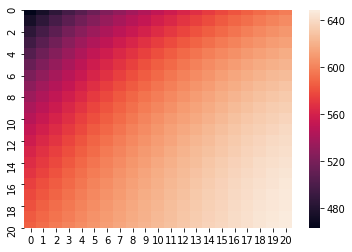

In [75]:
v = np.zeros((N_CARS+1, N_CARS+1))
value_itr(v)
print(v.min(), v.max())
sns.heatmap(v)

Expected result:

421.4136554821914 636.9894057704319

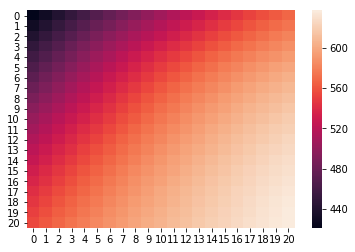

# show the greedy policy

In [76]:
def greedy(v):
    """return the greedy policy wrt. a given value table"""
    pi = np.zeros((N_CARS+1, N_CARS+1))
    # code here ...
    # ...
    discount_factor = 0.9
    # For loop each state 
    for i in range(0, N_CARS+1):
        for j in range(0, N_CARS+1):
            # Step1: Get value
            value = v[i][j]

            # Step2: Bell man equation
            a_min = max(-5,-j,-(N_CARS-i))
            a_max = min(5,i,N_CARS-j)
            max_a = 0
            for a in range(a_min,a_max+1):
                p , r = step_env((i,j), a)
                expected_reward = r + (discount_factor * np.sum(p * v))
                if a ==-5 or expected_reward > max_a:
                    pi[i][j] = a
                    max_a = expected_reward    
    return pi

## verify the greedy solution policy

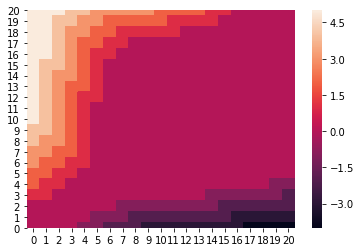

In [79]:
pi = greedy(v)
sns.heatmap(pi[::-1], xticklabels=range(N_CARS+1), yticklabels=list(reversed(range(N_CARS+1))))

Expected result:

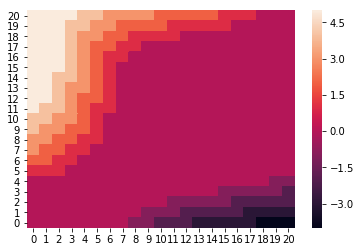

# If we change the renting and returning probabilities like the following:

In [80]:
P_RETURN_A = poisson.pmf(np.arange(0, N_CARS + 1), 0)
P_RENT_A = poisson.pmf(np.arange(0, N_CARS + 1), 4)
P_RETURN_B = poisson.pmf(np.arange(0, N_CARS + 1), 4)
P_RENT_B = poisson.pmf(np.arange(0, N_CARS + 1), 0)

## Q: what is an expected behavior?

From the poisson distribution of RETURN_A and RENT_B they tend to be 0 when we sampling from the distribution. That mean there aer no car enough for the location A. On the other hand, there are too many car on the location B. The best way to make the model get the maximum reward is to move the ca from location B to A as much as possible. The result is shown is below these code.

174.79961589573327
48.271561263871334
40.98535292154311
34.351636268063515
28.675089968567917
24.606903116397618
20.741876383007792
17.338028689084325
14.427159766280084
11.972004912075903
9.917389061102057
8.205770611272015
6.7839480873265074
5.605426508392469
4.629332197401482
3.8213342656562475
3.153140548210814
2.6009894760016437
2.144941737223661
1.7684387153844057
1.4577478040684753
1.2014500923505693
0.9900722948850671
0.8157901613660954
0.6721288761689834
0.5537428615125748
0.4562036522686981
0.3758321752993652
0.3096008034148383
0.25503133699044156
0.2100833435089271
0.17305950783662638
0.14255789890438564
0.11742816073967788
0.09672474480083793
0.0796689292082533
0.06561884663898354
0.05404535604401417
0.04451229173224647
0.03666018140728511
0.03019280106622091
0.0248660735369981
0.020478906325706703
0.016865633261204493
0.01388978133013552
0.011438931699444765
0.009420483699898341
0.0077581636583090585
0.00638914796491008
0.005261692544308971
0.004333179756258687
0.003568509

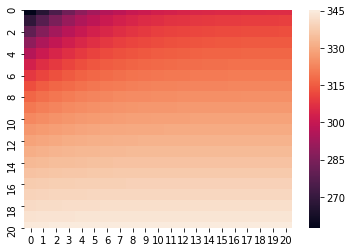

In [81]:
k = np.zeros((N_CARS+1, N_CARS+1))
value_itr(k)
print(k.min(), k.max())
sns.heatmap(k)

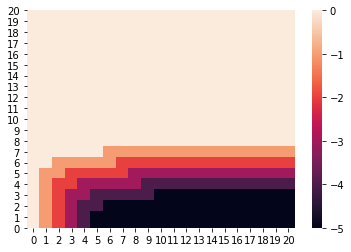

In [82]:
pi2 = greedy(k)
sns.heatmap(pi2[::-1], xticklabels=range(N_CARS+1), yticklabels=list(reversed(range(N_CARS+1))))